# Non cartesian discretizations.

This is a notebook meant for internal communication.
We describe here two ways to define non cartesian grid:
- by interpolating on a cartesian product of increasing (but non equally spaced) points
- by performing a monotone mapping of each dimension
These are currently implemented in `dolark.dolo_improvements`. Among other things,
this file contains an experimental rewrite of the decision_rule object which could
supersede the current implementation in dolo.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from dolo.compiler.language import language_element, eval_data
from dolo.compiler.language import eval_data
import ruamel.yaml as ry
eval_txt = lambda txt: eval_data(ry.round_trip_load(txt))

## Interpolation on non cartesian grids.

Package interpolate.py, can interpolate (multi)linearly on noncartesian grids.
We need to add these grids to the language and add relevant capability to the decision rule object.

### Non cartesian grids.

Proposed syntax is very simple. ICartesianGrid is defined in `dolo_improvements`.

Quation: what should be the name of this kind of grids? It would feel natural to me to call them `CartesianGrid` but this clashes with some previous uses? If nobody comes up with a better name, I would try to provide two constructors `CartesianGrid(,)` and `CartesianGrid(a=, b=, n=)` which would return respectively a `ICartesianGrid` and `UCartesianGrid` (or `IGrid` and `UGrid` as in `interpolation.py`)

In [3]:
from dolark.dolo_improvements import ICartesianGrid

# IrregularCartesianGrid: argument is a list of numpy arrays.
icgrid = ICartesianGrid([ 
    np.exp(np.linspace(0,1,10)),
    np.linspace(0,1,10)
])

In [4]:
# Let's add it to the language
@language_element
def IrregularCartesianGrid(*axes):
    return ICartesianGrid(axes)

txt = """
grid: !IrregularCartesianGrid
    - [0.0, 0.01, 0.02, 0.05, .1]
    - [0.1, 0.2]
"""
eval_txt(txt)

{'grid': <dolark.dolo_improvements.ICartesianGrid at 0x7f6315727668>}

Complementary to the syntax above some new ways of constructing vectors could be added to the language (lists are automatically constructed to numpy arrays). For instance we could have
grid: !IrregularCartesianGrid
    - 
    - !linspace
        a: 0
        b: 1
        n: 10


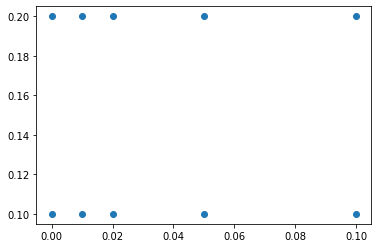

In [5]:
grid = eval_txt(txt)['grid']
plt.plot(grid.nodes[:, 0], grid.nodes[:,1], 'o')

## The Decision Rue object is amended to interpolate on such grids.

This is done in `dolo_improvements.py`. Other combinations of exogenous grids need to be added.

```python

# UnstructuredGrid x ICartesian x Linear
@multimethod
def get_coefficients(itp, exo_grid: UnstructuredGrid, endo_grid: ICartesianGrid, interp_type: Linear, x):
    return [x[i].reshape(tuple(endo_grid.n)+(-1,)).copy() for i in range(x.shape[0])]

@multimethod
def eval_is(itp, exo_grid: UnstructuredGrid, endo_grid: ICartesianGrid, interp_type: Linear, i, s):

    from interpolation.splines import eval_linear
    assert(s.ndim==2)

    grid = endo_grid # one single CartesianGrid
    coeffs = itp.coefficients[i]
    gg = endo_grid.axes

    return eval_linear(gg, coeffs, s)

```

improvements ideas: 
- grid should have a `.numba_repr()` method that would return a numba compatible object. In the piece of code above, it could be called instead of .axes then the multimethod would work equally for Cartesian and NonCartesian grids (it is already the case for the get_coefficients method)


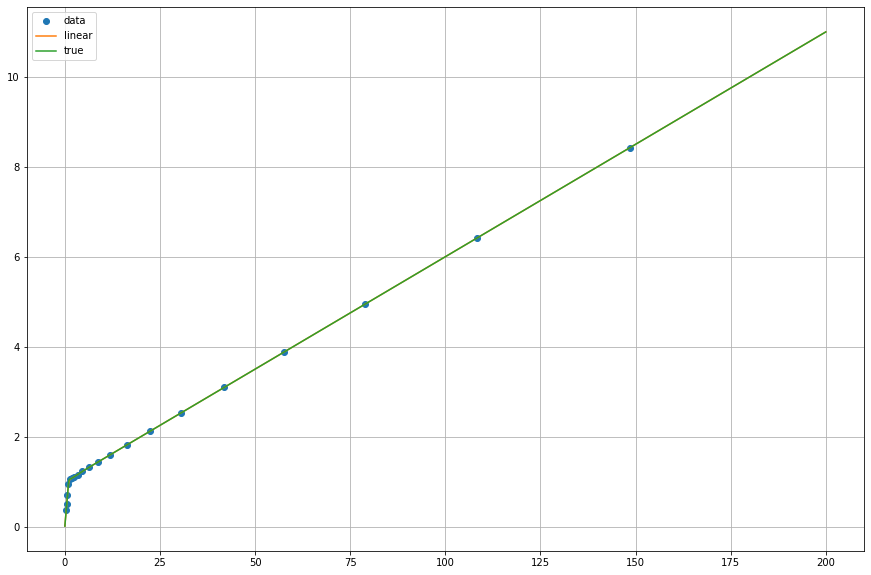

In [6]:
from dolark.dolo_improvements import Linear, \
    EmptyGrid, WarpGrid, CartesianGrid, ICartesianGrid, \
    UnstructuredGrid, DecisionRule, Cubic
import numpy as np
from matplotlib import pyplot as plt

# placeholder
exo_grid = UnstructuredGrid(np.array([[0.2, 0.5, 0.7]]))

# construction of the endogenous grid
N = 20
a = np.exp( np.linspace(-1,5,N) )
endo_grid = ICartesianGrid([a])
# f = lambda x: (x[:,0]**2)[:,None]
f = lambda x: np.minimum(x[:,0],1+0.05*(1+(x[:,0]-1)*(1-np.exp(1-(x[:,0])))))[:,None]
nodes = endo_grid.nodes
vals = f(nodes).reshape((1,N,1))

# Creation of the decision rule
dr = DecisionRule(exo_grid, endo_grid, 'linear')
dr.set_values(vals)

# Evaluation on a finer grid
fg = CartesianGrid([0.01], [200], [1000])
nn = fg.nodes
tvals = f(nn)
xx = dr.eval_is(0, nn)

plt.figure(figsize=(15,10))
plt.plot(nodes.ravel(), vals.ravel(), 'o', label='data')
plt.plot(nn.ravel(), xx.ravel(), label='linear')
plt.plot(nn.ravel(), tvals.ravel(), label='true')
plt.legend(loc='upper left')
plt.grid()


## Warped interpolation

We need to approximate a function $x=\varphi(s)$ where $s=\mathcal{W}^{1}(\tilde{s})$. The idea is to discretize the values of $s$ so that the values of $\tilde{s}$ are discretized uniformly. Then we can say that the grid for $s$ is a warped grid.

First syntax we propose defines a grid for $s$ and a tranformation function (or a list of transformation functions if there are many dimensions).

In [7]:
from dolark.dolo_improvements import multimethod, get_coefficients, eval_is, eval_ms, Linear, EmptyGrid, WarpGrid, CartesianGrid, UnstructuredGrid, DecisionRule, Cubic
import numpy as np


In [8]:
base = CartesianGrid([0.0,0], [1.0,1.0], [10,10])
wg = WarpGrid(
    base,
    ['exp',''] # list of transformation functions (so far only id, exp, exp(exp), exp(exp(exp)) are supported)
)

The equivalent yaml would be: (not implemented)

```yaml
!WarpGrid
    base: !CartesianGrid
        a: [0.0, 0.0]
        b: [1.0, 1.0]
        n: [10, 10]
    warp:
        [exp, '']
   
```

This is a one to one mapping with the python object, but many other syntaxes could be feasible. For instance:

```yaml
!CartesianGrid
    a: [0.0, 0.0]
    b: [1.0, 1.0]
    n: [10, 10]
    warp: [exp, '']
```    

However, it is not clear to me that such an option if interesting enough to be added to the default grid constructor.


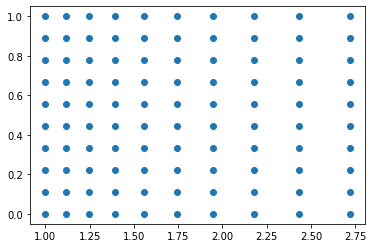

In [9]:
plt.plot(wg.nodes[:,0], wg.nodes[:,1], 'o')

### Decision rules are adapted to deal with warped grids

```python
@multimethod
def get_coefficients(itp, exo_grid, endo_grid: WarpGrid, interp_type, x):
    return get_coefficients(itp, exo_grid, endo_grid.base, interp_type, x)

@multimethod
def eval_is(itp, exo_grid, endo_grid: WarpGrid, interp_type, i, s):
    base = endo_grid.base
    ss = s.copy()
    for k,f in enumerate(endo_grid.warp_ifunctions):
        ss[:,k] = f(ss[:,k])
    return eval_is(itp, exo_grid, base, interp_type, i, ss)

@multimethod
def eval_ms(itp, exo_grid, endo_grid: WarpGrid, interp_type, m, s):
    base = endo_grid.base
    ss = s.copy()
    for i,f in enumerate(endo_grid.warp_ifunctions):
        ss[:,i] = f(ss[:,i])
    return eval_ms(itp, exo_grid, base, interp_type, m, ss)
```

- pros:
    - this is compatible with any interpolation method already defined (for instance, linear, cubic)
    - faster if many points
- cons:
    - monotonicity is preserved but not concavity/convexity (it does not look good, when trying to interpolate asymptotically linear functions)
    - extrapolation would need to be defined separately


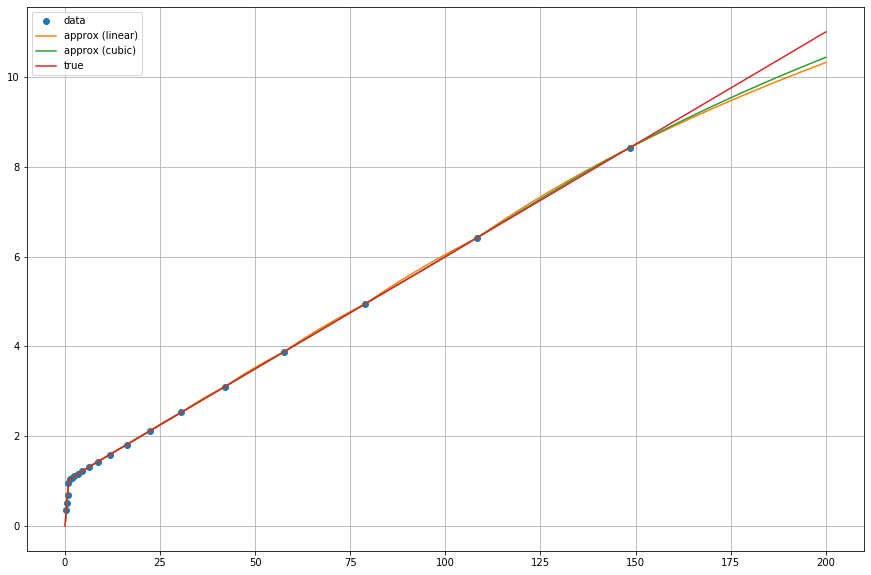

In [10]:
# place holder
exo_grid = UnstructuredGrid(np.array([[0.2, 0.5, 0.7]]))
N=20

g = WarpGrid(
    CartesianGrid([-1], [5], [N]),
    ['exp'] )
f = lambda x: np.minimum(x[:,0],1+0.05*(1+(x[:,0]-1)*(1-np.exp(1-(x[:,0])))))[:,None]
nodes = g.nodes
vals = f(nodes).reshape((1,N,1))


dr = DecisionRule(exo_grid, g, 'linear')
dr.set_values(vals)

dr2 = DecisionRule(exo_grid, g, 'cubic')
dr2.set_values(vals)

fg = CartesianGrid([0], [200], [1000])
nn = fg.nodes

tvals = f(nn)
xx = dr.eval_is(0, nn)
xx2 = dr2.eval_is(0, nn)

plt.figure(figsize=(15,10))
plt.plot(nodes.ravel(), vals.ravel(), 'o', label='data')
plt.plot(nn.ravel(), xx.ravel(), label='approx (linear)')
plt.plot(nn.ravel(), xx2.ravel(), label='approx (cubic)')
plt.plot(nn.ravel(), tvals.ravel(), label='true')
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,10)
# plt.xlim(100,120)
plt.legend(loc= 'upper left')
plt.grid()
